In this notebook, we transform raw datasets to parquet format to enable faster loading speed during training and evaluation.

The raw format of released datasets is as follows:
```python
# train set
/train/real/...
/train/fake/...
/train/masks/...
# valid set
/valid/real/...
/valid/fake/...
/valid/masks/...
```

In [1]:
import os
from datasets import Dataset, DatasetDict
from datasets import Features, Image
from typing import List


def load_images_from_dir(directory: str) -> List[str]:
    return [
        os.path.join(directory, fname)
        for fname in os.listdir(directory)
        if fname.endswith(("jpg", "jpeg", "png"))
    ]


def create_split(root_dir: str, split: str) -> Dataset:
    fake_dir = os.path.join(root_dir, split, "fake")
    masks_dir = os.path.join(root_dir, split, "masks")
    real_dir = os.path.join(root_dir, split, "real")

    fake_images = load_images_from_dir(fake_dir)
    mask_images = load_images_from_dir(masks_dir)
    real_images = load_images_from_dir(real_dir)

    assert len(fake_images) == len(mask_images)

    return Dataset.from_dict(
        {
            "image": fake_images + real_images,
            "mask": mask_images + [None] * len(real_images),
        },
        features=Features(
            {"image": Image(), "mask": Image()}
        ),
    )


def create_dataset(root_dir: str) -> DatasetDict:
    train_dataset = create_split(root_dir, split="train")
    valid_dataset = create_split(root_dir, split="valid")

    return DatasetDict({"train": train_dataset, "valid": valid_dataset})

root_dir = "/gemini/space/lye/track1"

/root/miniconda3/envs/loupe/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We merge `real/` and `fake/` into `images` column for simplity. A image is real if there is no corresponding mask.

In [ ]:
dataset = create_dataset(root_dir)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 954931
    })
    valid: Dataset({
        features: ['image', 'mask'],
        num_rows: 238733
    })
})

Then save processed datasets to parquet.

In [ ]:
trainset = dataset["train"]
validset = dataset["valid"]
trainset.to_parquet(os.path.join(root_dir, "train.parquet"))
validset.to_parquet(os.path.join(root_dir, "valid.parquet"))

Load from processed datasets to do whatever you want.

In [14]:
import os
from datasets import load_dataset

validset = load_dataset(
    "parquet", data_files=os.path.join("/gemini/space/jyc/track1", "valid.parquet")
)
validset

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 238733
    })
})

In [7]:

import hydra
hydra.initialize(config_path="configs")

/tmp/ipykernel_447621/989117794.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")


hydra.initialize()

In [ ]:
import sys

from models.loupe.configuration_loupe import LoupeConfig
from models.loupe.modeling_loupe import LoupeModel
sys.path.insert(0, "./src")
from lit_model import LitModel

cfg = hydra.compose(config_name="base.yaml", overrides=["stage=seg"])
cfg.model.backbone_path = "results/checkpoints/loupe-epoch=0-val_loss=7.8660.ckpt/output_dir/model.safetensors"
loupe_config = LoupeConfig(stage=cfg.stage.name, **cfg.model)
model = LoupeModel(loupe_config)
model = LitModel(cfg, model)

2025-05-07 23:40:55.921 | INFO     | models.loupe.modeling_loupe:__init__:511 - Loading backbone from results/checkpoints/loupe-epoch=0-val_loss=7.8660.ckpt/output_dir/model.safetensors


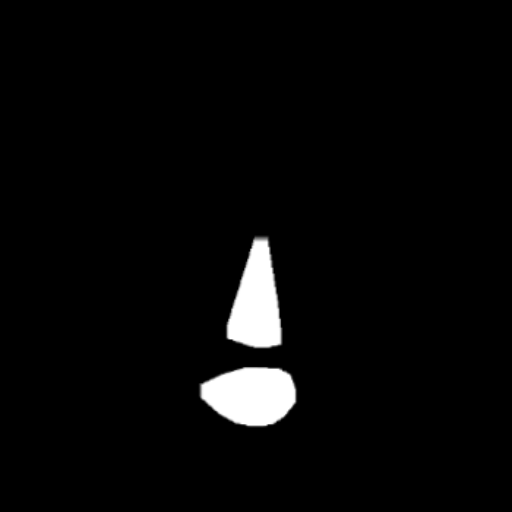

In [16]:
image, mask = validset["train"][0]["image"], validset["train"][0]["mask"]
mask

In [20]:
import torch


pixel_values = model.processor(image)['pixel_values'][0]
with torch.no_grad():
    outputs = model(pixel_values.unsqueeze(0), None, None, None)

In [34]:
class_queries_logits = outputs["class_queries_logits"]  # [batch_size, num_queries, num_classes]
masks_queries_logits = outputs["masks_queries_logits"]  # [batch_size, num_queries, height, width]
masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
masks_probs = (
    masks_queries_logits.sigmoid()
)  # [batch_size, num_queries, height, width]

# Semantic segmentation logits of shape (batch_size, num_classes, height, width)
segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)

In [45]:
segmentation.shape
semantic_segmentation = segmentation.argmax(dim=1)
semantic_segmentation.shape
# semantic_segmentation = [
#     semantic_segmentation[i] for i in range(semantic_segmentation.shape[0])
# ]
segmentation

tensor([[[[2.2471e-11, 5.1859e-12, 1.0466e-11,  ..., 2.2691e-11,
           2.7380e-11, 7.6330e-12],
          [2.2168e-11, 1.1153e-10, 1.1145e-11,  ..., 8.3585e-11,
           4.6092e-11, 3.7372e-11],
          [2.6748e-11, 1.4359e-11, 2.2273e-11,  ..., 4.9178e-11,
           2.7871e-10, 2.2155e-11],
          ...,
          [1.0969e-09, 9.6234e-10, 7.9608e-09,  ..., 4.1182e-09,
           1.1809e-09, 3.6254e-09],
          [4.9677e-10, 5.3348e-09, 2.4710e-09,  ..., 1.9082e-09,
           1.6144e-09, 8.7366e-10],
          [2.9654e-09, 7.5575e-10, 7.5556e-09,  ..., 4.9987e-09,
           1.8747e-09, 2.2270e-09]]]])

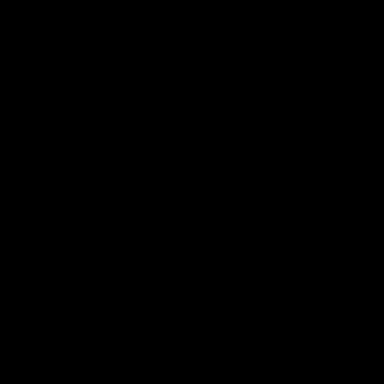

In [32]:
from PIL import Image
pred = model.processor.post_process_segmentation(
    outputs["class_queries_logits"], outputs["masks_queries_logits"]
)[0]
numpy_array = pred.numpy()
image = Image.fromarray(numpy_array * 255, mode="L")
image.show()